# Synthetic Control: USA cities traffic

In this notebook we showcase the use of synthetic control for analysis a test.

In [1]:
%load_ext autoreload
%autoreload 2

# set-up
import sys, os 
from dotenv import load_dotenv
load_dotenv("../.env")
sys.path.append(os.environ.get("SRC_FOLDER"))

In [2]:
import pandas as pd 
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt 
import plotly.subplots

# Parameters 
random_factor = 9374

import causalinf.th
import causalinf.ab.synthetic_control
import causalinf.plot

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Data Explotation

In [3]:
df = pd.read_csv(os.path.join(os.environ.get("SRC_FOLDER"), "tests/fixtures/ga-visits-usa-cities.csv"))
df = causalinf.libs.pd_tools.format_dataframe( df, columns_datetime = ["period_start_date"])
df.head(3)

# Define treated and control units
treated_unit = "Houston"
control_units = [cc for cc in df.columns if cc not in [treated_unit, "period_start_date", "test_active"]]
step_intervention =  df[df["test_active"]==1].index.min()

# split data: pre/post test
# df = df.set_index("period_start_date")
mask_pre = df["test_active"]==0
df_pre, df_post = df.loc[mask_pre,[treated_unit]+control_units], df.loc[~mask_pre,[treated_unit]+control_units]


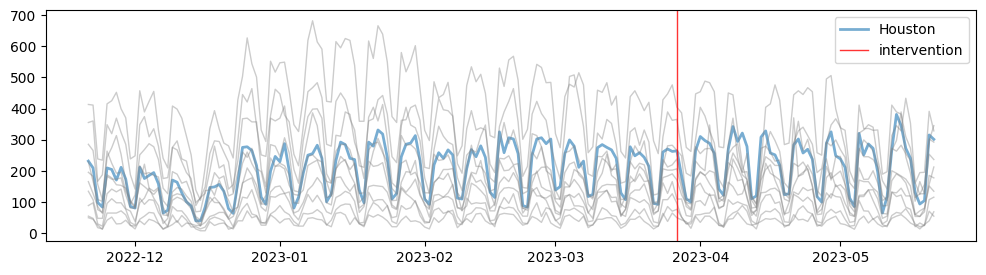

In [4]:
fig = plt.figure(figsize=(12.,3.))
Ax = fig.subplots(1,1,squeeze=False)
ax = Ax[0,0]
causalinf.plot.main.plot_units(df, treated_unit, control_units, step_intervention, col_time="period_start_date",  plot_args={"ax": ax}, backend="matplotlib" )
ax.legend()
plt.show()

## Fit Synthetic Control Model

Here are some recommendations on how to set the model parameters:

-  `coef_bounds`: Ideally, avoid negative coefficients or much larger than 1.
- `fit_intercept`: Ideally, try without fitting an intercept - use only if needed. When using, try to avoid large values of the intercept (as these may be unphysical and hard to justify to the client), unless you have a valid reason for doing so.
- `l1_ratio`. This is a regularisation term as per [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html). Higher values will help removing from the control covariates less impactful covariates. Optionally, you can use the `sc.fit_hyperparameters` method to optimise the `l1_ratio`.

In [5]:
dX_pre, dy_pre = df_pre[control_units], df_pre[[treated_unit]]
dX_post, dy_post = df_post[control_units], df_post[[treated_unit]]

In [6]:
model_params = dict(
    coef_bounds=(0.0, 1.2),
    fit_intercept = True
)
sc = causalinf.ab.synthetic_control.linear.models.GeneralRegressor(**model_params)
# sc.fit_hyperparameters(dX_pre.values, dy_pre.values)
sc._fit_intercept(dX_pre, dy_pre)
sc.fit(dX_pre, dy_pre)

print(f"Fit stats:\n"+sc._fit_stats.__str__())

Fit stats:
error_mean: 0.001
error_std: 27.107
r2: 0.88
mse: 734.808
rmse: 27.107



In [7]:
sc._coef_stats = sc._coef_stats.sort_values(by="mean", ascending=True)
display(sc._coef_stats)

,mean,sd
Los Angeles,0.000000e+00,0.0
Miami,1.617177e-14,0.0
Las Vegas,7.394081e-03,0.0
Dallas,7.207567e-02,0.0
Boston,7.907952e-02,0.0
Atlanta,8.277025e-02,0.0
Phoenix,2.390947e-01,0.0
Austin,4.189643e-01,0.0
New Orleans,5.769881e-01,0.0
San Antonio,8.462649e-01,0.0


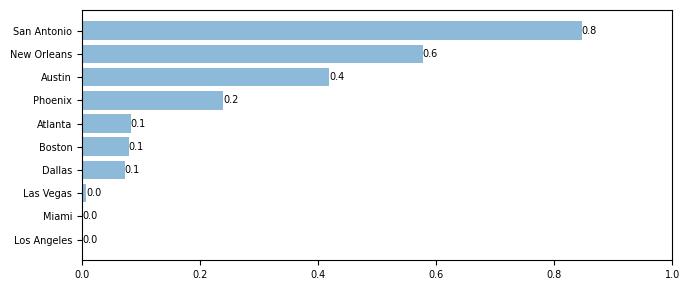

In [8]:
fig = plt.figure(figsize=(7.,3.))
Ax = fig.subplots(1,1,squeeze=False)
ax = Ax[0,0]
causalinf.plot.main.plot_coefficients(sc, add_value=True, text_format=".1f", ax=ax)
ax.tick_params(axis='y', labelsize=7)
ax.tick_params(axis='x', labelsize=7)
ax.set_xlim(0, 1)
fig.tight_layout()

## Inference

The inference process, happens at different level. 
1. We compute the cumulative causal impact over the whole campaign period. Here, we want to verify that the uncertainty around this value is *low enough* (see discussion below).
2. Next, we perform an AB test to ensure that the *mean* (daily) figures predicted by the counterfactual (null hp) are significantly different from the *mean* (daily) observed values (alternative Hp: the campaign has had an impact).

In [9]:
inference_model = causalinf.ab.synthetic_control.core.inference.InferenceModel(
    df_pre, df_post, sc, treated_unit, control_units, confidence_level=0.95
)
inference_model.compute()

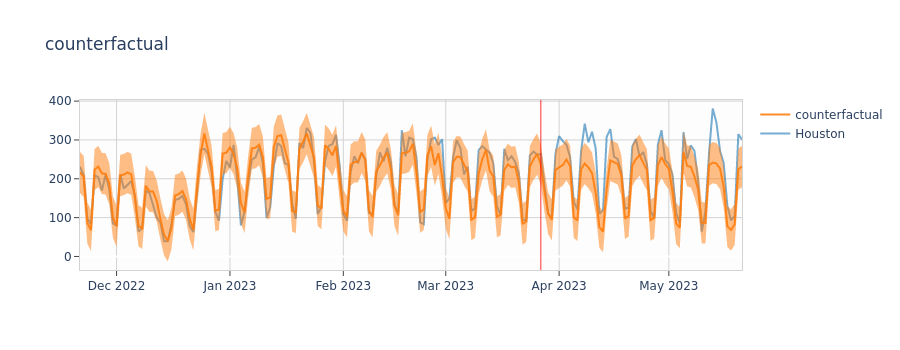

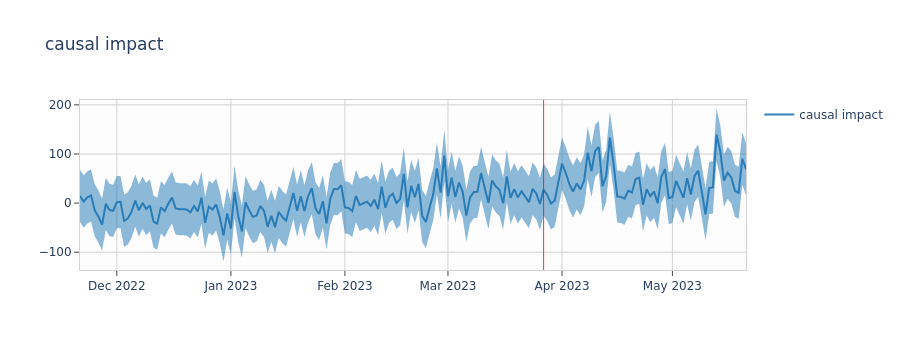

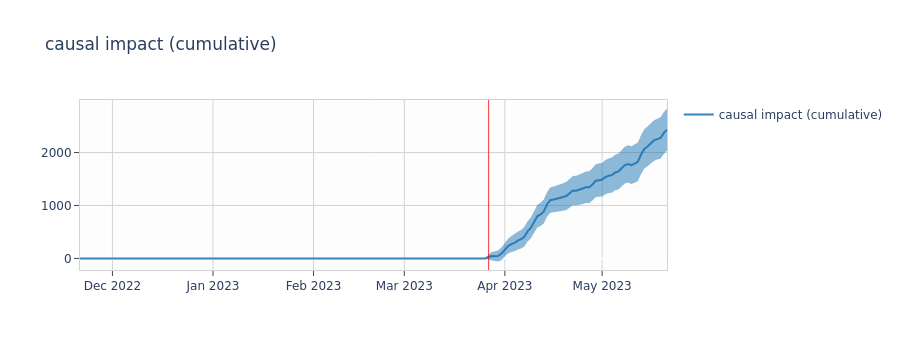

In [10]:
### Matplotlib backend 
# fig, Ax = causalinf.plot.main.plot_study(
#      df, treated_unit, inference_model.counterfactual, inference_model.causal_impact, 
#      inference_model.causal_impact_cum, step_intervention, figsize=(12.,9.),
#      col_time="period_start_date"
# )

### Plotly backend (requires import of `plotly.subplots`)
figs = causalinf.plot.main.plot_study(
     df, treated_unit, inference_model.counterfactual, inference_model.causal_impact, 
     inference_model.causal_impact_cum, step_intervention, backend="plotly", figsize=(900,350),
     col_time="period_start_date"
)
# for interactive figures - commented out as they won't render in github
# for _f in figs:
#     _f.show()
# for static render (as "png", "svg"; see plotly.io.renderers for all available options)
for _f in figs:
    _f.show("png")

# # You can save figures from this notebook, or programmatically, as below:
# fig.write_image( os.path.join( figs_path, "demo-backend-plotly.png"))
# fig.write_image( os.path.join( figs_path, "demo-backend-plotly.pdf"))

# # You can also export figures as html, e.g. for sharing with/presentig to clients
# fig.write_html( os.path.join( figs_path, "demo-backend-plotly.html"))

The confidence interval around the cumulative impact by the end of the campaign is small enough so as not to include 0. In practice, while there is some uncertanty around the cumulative impact (due to errors in our counterfactual), we are quite confident that we have observed an uplift. However, we can't claim yet that this is significant: maybe, it has happened just by chance!

To verify this, therefore, we perform an AB test and compare the mean (daily) sessions of counterfactual (null Hp: the campaign had no effect) and observed values (alternative Hp: the campaign has had an effect).

In [11]:
inference_model.run_t_test()
_ = inference_model.get_summary_data()
inference_model.print_summary()
# use n_digits option to increase accuracy, e.g.
# >>> inference_model.print_summary(n_digits=4)


Below we look for (significant) differences between the mean of: actual and prediction .
The confidence intervals refer to the mean statistic. If they don't overlap, the mean of the two 
groups is likely to be significantly different.

                                        Average                                 Cumulative
actual (s.d.)                           226.86 (11.46)                          12704.0 (641.77)
CI (95.0%)                              [203.89, 249.82]                        [11417.86, 13990.14]

prediction (s.d.)                       183.38 (9.05)                           10269.12 (506.92)
CI (95.0%)                              [165.24, 201.52]                        [9253.22, 11285.02]

Absolute effect (s.d.)                  43.48 (9.05)                            2434.88 (506.92)
CI (95.0%)                              [25.34, 61.62]                          [1418.98, 3450.78]

Relative effect (s.d.)                  23.71% (4.94%)                       

In this example, the test is successful. There is an impact and, in particular, the daily sessions observed are significantly higher than the counterfactual. 

This is confirmed by looking at the means distributions in the pre and post period. While these overlap in the pre-period, they are significantly shifted in the post period.

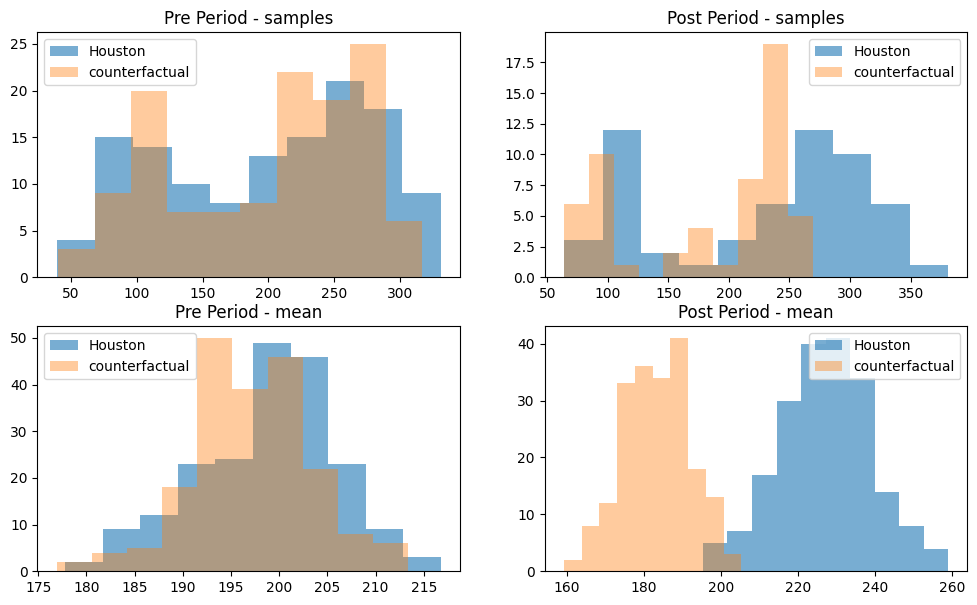

In [12]:
_ = causalinf.plot.main.plot_counterfactual_distributions(
    df, treated_unit, inference_model.counterfactual, step_intervention
)

## Inference - Alternative Method 1

This second approach follows [Doudchenko and Imbens (2017)](https://arxiv.org/pdf/1610.07748.pdf). For each control unit we fit a synthetic control using the remaining units - including the treated unit. For each, we compute the ratio between a fit metric, $R$ (typicaly the mean square error, MSE, or root mean square error, RMSE) in the post and the pre period:
$$
\Phi_j = \frac{{R}_{post, j}}{{R}_{pre, j}}
$$
where $i$ is the control units. Typically, $\Phi_i>1$, as the fit of the synthetic control worsen when this is tried on unseen data. However, if the test campaign is having an impact (be this positive or negative), it is expect the fit to worsen even more. Namely, being $i$ the subscript associated to the treated unit, it is likely to have $\Phi_i > \Phi_j$ ($i\neq j$) if the treatment (campaign) is having a significant impact.

For each unit $j$, a $p$ value is computed as:
$$
p_j = \frac{N_{H,j}}{N}
$$
where $N$ is the total number of units (including the treated unit) and $N_{H,j}$ is the number of units with $\Phi_k>\Phi_j$. The campaign is expected to have had a significant impact when $p_j \ll 1$.

**Note**: this approach does not provide a high granularity when a low number of control units is used. Also, it is recommended to excude from the analysis:
1. control units who do not have a high contribution to the synthetic control of the treated unit. 
1. control units whose fit, in the pre-period, is considerably worse than the other units. If the fit is very bad ($R_{pre} \gg 1$), in fact, it is reasonable to observe a $R_{post}$ comparable to $R_{pre}$, which may fake the experiment.

In [13]:
# Fit a synthetic control for all control units.
# - Each control unit is sequentially considered as a treated unit.
# - We use the same model class and parameters used above.
inference_models = causalinf.ab.synthetic_control.core.inference.fit_predict_all(
    df_pre, df_post, 
    causalinf.ab.synthetic_control.linear.models.GeneralRegressor,
    model_params    
)

In [14]:
df_p_values = causalinf.ab.synthetic_control.core.inference.from_scores_to_p_values( 
    { unit: im for unit,im in inference_models.items() },
    kpi = "rmse_norm",
    treated_unit = treated_unit,
    coef_limit = 1e-4,
    remove_n_worse_scores = 0
    )
df_p_values

Removing unit Los Angeles. Low importance in synthetic control of treated unit (coef <= 0.000)
Removing unit Miami. Low importance in synthetic control of treated unit (coef <= 0.000)


,kpi,pre,post,ratio_pre_post,p_value
Atlanta,rmse_norm,0.094177,0.295685,3.139680,0.000000
Dallas,rmse_norm,0.113444,0.206512,1.820396,0.111111
Houston,rmse_norm,0.136922,0.244829,1.788086,0.222222
Boston,rmse_norm,0.125866,0.177129,1.407281,0.333333
San Antonio,rmse_norm,0.168961,0.217829,1.289226,0.444444
Las Vegas,rmse_norm,0.120020,0.153625,1.279992,0.555556
New Orleans,rmse_norm,0.225233,0.233233,1.035515,0.666667
Phoenix,rmse_norm,0.119851,0.121473,1.013541,0.777778
Austin,rmse_norm,0.164498,0.162110,0.985483,0.888889


## Inference - Alternative Method 3

This third approach is similar to the one presented before. For each unit $j$, we look at the (normalised) cumulative causal impact over the post period, $C_j$. We then sort the $C_j$ coefficients and, for each unit $j$ we compute the p-values:
$$
p_{L,j} = \frac{N_{L,j}}{N}
$$
and
$$
p_{H,j} = \frac{N_{H,j}}{N}
$$

where:
- $N$ is the total number of units (including the treated unit);
- $N_{H,j}$ is the number of units with $\Phi_k>\Phi_j$; and
- $N_{L,j}$ is the number of units with $\Phi_k<\Phi_j$.

The campaign is expected to have had a significant impact when either $p_{L,j} \ll 1$ or $p_{H,j} \ll 1$. In particular:
- when $p_{H,j} \ll 1$, the campaign is likely to have caused a downlift.
- when $p_{L,j} \ll 1$, the campaign is likely to have cause an uplift.

In order to provide better granularity, bootstrapping is used to compute $C_j$ over multiple sub-sample of the post period. This strategy was also  suggested by [Doudchenko and Imbens (2017)](https://arxiv.org/pdf/1610.07748.pdf), who applied it to the calculation of the $\Phi_j$ ratios introduced in the previous section. 



In [15]:
df_p_values = causalinf.ab.synthetic_control.core.inference.from_causal_impacts_to_p_values(
    # {unit: im.causal_impact for unit,im in inference_models.items()},
    {unit: im for unit,im in inference_models.items()},
    treated_unit = None,
    resample = True, 
    sample_fraction = 0.9,
    n_repeat = 100,
    replace = True, 
    random_state = None
    ) 
df_p_values

,p_value_lower,p_value_higher,avg_cum_impact_norm
Houston,0.00000,1.00000,11.181477
Dallas,0.89254,0.10746,-5.227621
Austin,0.53233,0.46767,-0.563571
San Antonio,0.74089,0.25911,-2.669213
New Orleans,0.60909,0.39091,-1.351775
Los Angeles,0.65924,0.34076,-1.698490
Atlanta,0.99884,0.00116,-8.664182
Phoenix,0.41254,0.58746,0.499012
Miami,0.10856,0.89144,5.082693
Las Vegas,0.31835,0.68165,1.465358


# Alternative Visualisation
Below, we show the causal impact of the treated unit against those of all other units.

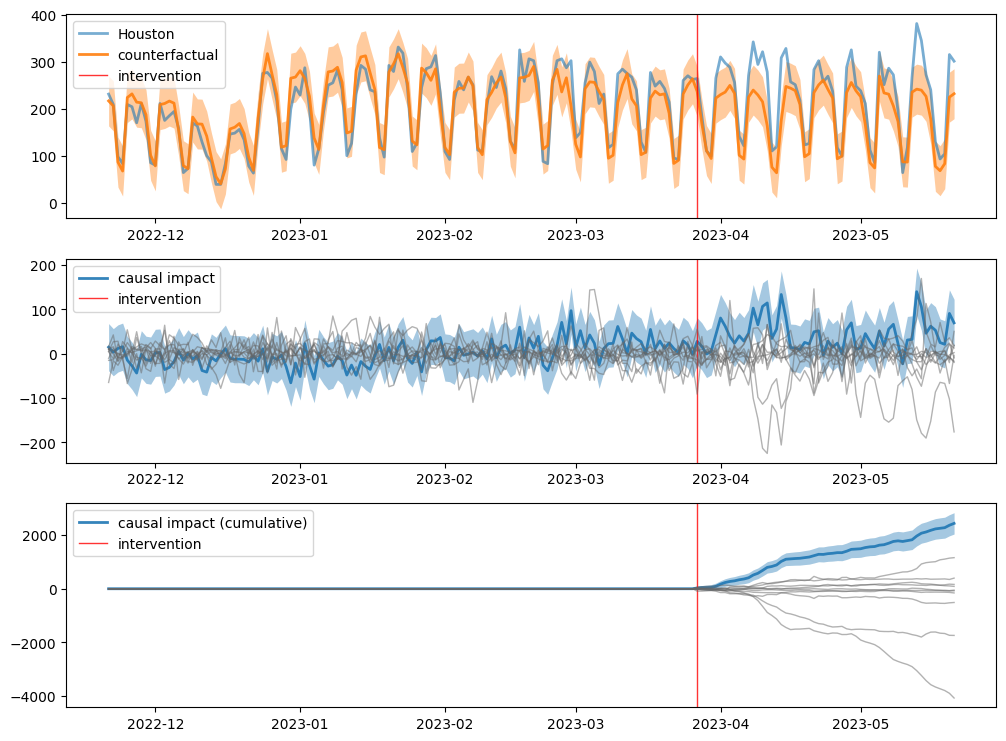

In [16]:
fig, Ax = causalinf.plot.main.plot_study(
     df, treated_unit, inference_model.counterfactual, inference_model.causal_impact, 
     inference_model.causal_impact_cum, step_intervention, figsize=(12.,9.),
     col_time="period_start_date"
)
_kwargs_ctrl_units = dict(lw=1, ls="-", alpha=.5, color="0.4")

ax = Ax[1,0]
for col in control_units:
    ax.plot(
        df["period_start_date"],
        inference_models[col].causal_impact["mean"]["full"], 
        **_kwargs_ctrl_units
    )
ax = Ax[2,0]
for col in control_units:
    ax.plot(
        df["period_start_date"],
        inference_models[col].causal_impact_cum["mean"]["full"], 
        **_kwargs_ctrl_units
    )